# Transfer Learning avec divers modèles de classification pré-entraînés

Dans ce Notebook, nous souhaitons comparer les performances de différents modèles avec la technique du Transfer Learning. Les modèles sont tous entraînés avec les mêmes hyper-paramètres et le même nombre d'epochs, en appliquant une stratégie d'augmentation de données.

Certains modèles seraient peu-être plus performants avec l'utilisation d'autres hyper-paramètres mais le but ici est d'essayer de les départager et d'étudier plus en profondeur le meilleur modèle trouvé lors de la prochaine étape.

Imports des bibliothèques pour le projet

In [1]:
import time
import itertools
import os
import numpy as np
import pandas as pd
import sys

"""
plot de graphes
"""
import matplotlib.pyplot as plt

"""
Création et gestion des modèles de classification d'images avec Keras
"""
from tensorflow import keras

#Accès aux images à classifier, qui sont réparties dans différents dossiers
from keras.preprocessing.image import ImageDataGenerator

#Différents types de couches pour les CNN
from keras.layers import Flatten, Dense, Activation

#Création de l'architecture des modèles avec Model
from keras.models import Model 

#Gestion des arrêtes anticipés
from keras.callbacks import EarlyStopping

#Utilisation de modèles enregistrés
from keras.models import load_model

"""
Importation des modèles pré-entraînés
"""

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_vgg16

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_vgg19

from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input as preprocess_resnet50

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as preprocess_xception

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as preprocess_inception_v3

from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inception_resnet_v2

from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input as preprocess_mobilenet

from keras.applications.densenet import DenseNet121, DenseNet201
from keras.applications.densenet import preprocess_input as preprocess_densenet

from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.applications.nasnet import preprocess_input as preprocess_nasnet

"""
Mesures de performance des modèles avec Sklearn
"""
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 1) Set up : fonctions utiles et initialisation

In [3]:
#infos du dataset
labels = os.listdir("./Garbage classification")
nClasses = len(labels) #6
inputFolder = "./Garbage_train_test_val"

#Hyper-paramètres
batch_size = 32
epochs_nb = 65

modelInputSize =   {"VGG16":             [224,224], #[width,height]
                    "VGG19":             [224,224],
                    "ResNet50":          [224,224],
                    "Xception":          [299,299],
                    "InceptionV3":       [299,299],
                    "InceptionResNetV2": [299,299],
                    "MobileNet":         [224,224],
                    "DenseNet121":       [224,224],
                    "DenseNet201":       [224,224],
                    "NASNetLarge":       [331,331],
                    "NASNetMobile":      [224,224]}

* **Gestion des différents modèles pré-entraînés**

In [4]:
def modelSettings(modelName):

  img_width = modelInputSize[modelName][0]
  img_height = modelInputSize[modelName][1]

  if (modelName == "VGG16"):
    preprocessing = preprocess_vgg16

  elif (modelName == "VGG19"):
    preprocessing = preprocess_vgg19

  elif (modelName == "ResNet50"):
    preprocessing = preprocess_resnet50

  elif (modelName == "Xception"):
    preprocessing = preprocess_xception

  elif (modelName == "InceptionV3"):
    preprocessing = preprocess_inception_v3

  elif (modelName== "InceptionResNetV2"):
    preprocessing = preprocess_inception_resnet_v2

  elif (modelName == "MobileNet"):
    preprocessing = preprocess_mobilenet

  elif (modelName== "DenseNet121" or modelName== "DenseNet201"):
    preprocessing = preprocess_densenet
  
  elif (modelName== "NASNetLarge" or modelName== "NASNetMobile"):
    preprocessing = preprocess_nasnet

  else :
      print("Impossible : ce modèle ne fait pas partie des modèles importés pour ce projet.")
      sys.exit()

  return img_width, img_height, preprocessing


def makeGenerators(modelName, inputFolder, batch_size):

  img_width, img_height, preprocessing = modelSettings(modelName)
  input_shape = (img_width, img_height, 3)


  train_datagen = ImageDataGenerator( preprocessing_function = preprocessing,
                                      width_shift_range=0.2, 
                                      height_shift_range=0.2, 
                                      horizontal_flip=True, 
                                      vertical_flip=True,
                                      rotation_range = 90,
                                      brightness_range = [0.8, 1.2],
                                      zoom_range = [0.8, 1],
                                      fill_mode='nearest')
  test_datagen = ImageDataGenerator(preprocessing_function = preprocessing)

  train_generator = train_datagen.flow_from_directory(directory=r'./{}/train'.format(inputFolder),
                                                      target_size=(img_width, img_height),
                                                      color_mode='rgb',
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      shuffle=True,
                                                      seed=42)
  test_generator = test_datagen.flow_from_directory(directory=r'./{}/test'.format(inputFolder),
                                                    target_size=(img_width, img_height),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)
  validation_generator = test_datagen.flow_from_directory(directory=r'./{}/val'.format(inputFolder),
                                                          target_size=(img_width, img_height),
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          shuffle=False)

  return input_shape, train_generator, test_generator, validation_generator


def testGenerator(modelName, inputFolder):

  img_width, img_height, preprocessing = modelSettings(modelName)
  input_shape = (img_width, img_height, 3)

  test_datagen = ImageDataGenerator(preprocessing_function = preprocessing)

  test_generator = test_datagen.flow_from_directory(directory=r'./{}/test'.format(inputFolder),
                                                    target_size=(img_width, img_height),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

  return test_generator


def Architecture(model, nClasses):
  
  #Partie convolutive : on garde les paramètres des couches convolutives
  for layer in model.layers:
    layer.trainable = False
    lastLayer = model.output

  x = Flatten()(lastLayer)

  #Partie classification : on ajoute une couche entièrement connectée ainsi que la dernière avec le bon nombre de classes
  #Seule cette partie sera entraînée par le modèle
  x = Dense(256)(x)
  x = Activation('relu')(x)
  x = Dense(nClasses)(x)
  x = Activation('softmax')(x)

  model = Model(model.input, x)

  return model

* **Etude des modèles**

In [5]:
def plot_accuracy_loss(history):
    """
    Retourne 2 graphes : un qui présente l'accuracy sur les sets de train et validation et le deuxième avec la loss
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    #Accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    ax1.plot(range(len(accuracy)), accuracy, label='train')
    ax1.plot(range(len(val_accuracy)), val_accuracy, label='validation')
    ax1.legend()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training and Validation Accuracy')

    #Loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.plot(range(len(loss)), loss, label='train')
    ax2.plot(range(len(val_loss)), val_loss, label='validation')
    ax2.legend()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training and Validation Loss')


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Affiche la matrice de confusion du modèle sur les données de test
    """
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def study_model(model, classes, test_generator, executionTime, plot_cm=False):
    """
    Retourne des informations sur la performance du modèle
    """

    #Durée d'entraînement
    print(f"Durée d'entraînement : {round(executionTime, 2)} secondes")

    #Performances sur le set de test
    preds = model.predict(test_generator)  # preds are proba for each class
    preds_classes = [i.argmax() for i in preds]
    y_true = test_generator.classes
    acc_test = accuracy_score(y_true, preds_classes)
    prec_test = precision_score(y_true, preds_classes, average='weighted')
    rec_test = recall_score(y_true, preds_classes, average='weighted')
    f1_test = f1_score(y_true, preds_classes, average='weighted')
    results = pd.DataFrame([[acc_test, prec_test, rec_test, f1_test]], columns=['accuracy', 'precision', 'recall', 'f1-score'])
    print("\nPerformances sur le set de test : \n")
    print(results)

    #Matrice de confusion
    if (plot_cm):
      cm = confusion_matrix(y_true, preds_classes)
      plot_confusion_matrix(cm, classes)

# 2) Etude de 9 nouveaux modèles pré-entraînés (en plus de VGG16)

## VGG19

Nous téléchargeons le modèle **VGG19 pré-entraîné sur ImageNet** et ne modifions que la partie classification (correspondant aux couches entièrements connectées). Les poids des couches convolutives de VGG19 sont donc conservées (layer.trainable = False).

In [ ]:
modelName = "VGG19"

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = VGG19(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_vgg19 = Architecture(model, nClasses)
model_vgg19.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
startTime=time.time()
history = model_vgg19.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)

Epoch 1/65
56/56 [==============================] - 530s 9s/step - loss: 4.9077 - accuracy: 0.3958 - val_loss: 3.5087 - val_accuracy: 0.5358
Epoch 2/65
56/56 [==============================] - 43s 760ms/step - loss: 3.1605 - accuracy: 0.5476 - val_loss: 2.5698 - val_accuracy: 0.6127
Epoch 3/65
56/56 [==============================] - 41s 725ms/step - loss: 2.3546 - accuracy: 0.6138 - val_loss: 2.1348 - val_accuracy: 0.6631
Epoch 4/65
56/56 [==============================] - 40s 718ms/step - loss: 1.9221 - accuracy: 0.6676 - val_loss: 1.8578 - val_accuracy: 0.6684
Epoch 5/65
56/56 [==============================] - 40s 719ms/step - loss: 1.6147 - accuracy: 0.6852 - val_loss: 1.7494 - val_accuracy: 0.6817
Epoch 6/65
56/56 [==============================] - 40s 718ms/step - loss: 1.4694 - accuracy: 0.7089 - val_loss: 1.6508 - val_accuracy: 0.7003
Epoch 7/65
56/56 [==============================] - 40s 717ms/step - loss: 1.3359 - accuracy: 0.7282 - val_loss: 1.4812 - val_accuracy: 0.7162
E

In [ ]:
model_vgg19.save(f'./Modeles/{modelName}.h5')

In [ ]:
study_model(model_vgg19, labels, test_generator, executionTime)

Durée d'entraînement : 3123.99 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.822917   0.826353  0.822917  0.822247


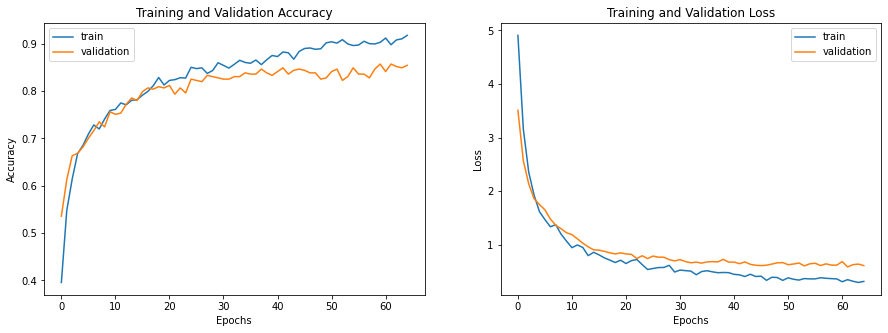

In [ ]:
plot_accuracy_loss(history)

Le modèle a-t-il convergé après 65 epochs ? Pas sûr

Il est préférable d'entraîner le modèle à nouveau sur quelques epochs.

In [ ]:
model_vgg19_2 = load_model(f"./Modeles/{modelName}.h5")
model_vgg19_2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
cb_list=[es]
epochs_nb = 35

In [ ]:
startTime=time.time()
history = model_vgg19_2.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator, callbacks=cb_list)
executionTime2 = (time.time() - startTime)

Epoch 1/35
56/56 [==============================] - 45s 773ms/step - loss: 0.3146 - accuracy: 0.9173 - val_loss: 0.6602 - val_accuracy: 0.8541
Epoch 2/35
56/56 [==============================] - 41s 748ms/step - loss: 0.2876 - accuracy: 0.9190 - val_loss: 0.6398 - val_accuracy: 0.8488
Epoch 3/35
56/56 [==============================] - 41s 732ms/step - loss: 0.3453 - accuracy: 0.9151 - val_loss: 0.6190 - val_accuracy: 0.8541
Epoch 4/35
56/56 [==============================] - 42s 746ms/step - loss: 0.2995 - accuracy: 0.9207 - val_loss: 0.6227 - val_accuracy: 0.8541
Epoch 5/35
56/56 [==============================] - 41s 727ms/step - loss: 0.2952 - accuracy: 0.9100 - val_loss: 0.6099 - val_accuracy: 0.8488
Epoch 6/35
56/56 [==============================] - 41s 748ms/step - loss: 0.3265 - accuracy: 0.9185 - val_loss: 0.5671 - val_accuracy: 0.8647
Epoch 7/35
56/56 [==============================] - 41s 728ms/step - loss: 0.2566 - accuracy: 0.9281 - val_loss: 0.6443 - val_accuracy: 0.8594

In [ ]:
model_vgg19_2.save(f'./Modeles/{modelName}_2.h5')

In [ ]:
study_model(model_vgg19_2, labels, test_generator, executionTime2)

Durée d'entraînement : 660.5 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.825521   0.827939  0.825521  0.824667


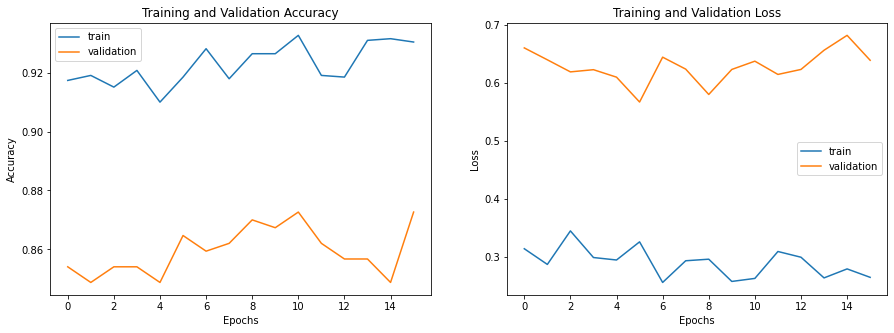

In [ ]:
plot_accuracy_loss(history)

Les résultats sur les sets d'entraînement et de validation ont légèrement augmenté (passant respectivement de 91 à 93% et de 85 à 87% d'accuracy). Cependant, les résultats sur le set de test ont à peine bougés : **82,5% d'accuracy**. Nous pouvons en conclure que le modèle avait bien convergé.

Les performances de VGG19 ne sont pas meilleures que celles de VGG16. De plus, le temps d'entraînement est plus long.

## ResNet50

In [ ]:
modelName = "ResNet50"
epochs_nb = 65

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_resnet50 = Architecture(model, nClasses)
model_resnet50.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
startTime=time.time()
history = model_resnet50.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_resnet50.save(f'./Modeles/{modelName}.h5')

Epoch 1/65
56/56 [==============================] - 48s 774ms/step - loss: 1.2637 - accuracy: 0.6212 - val_loss: 0.6737 - val_accuracy: 0.7560
Epoch 2/65
56/56 [==============================] - 40s 705ms/step - loss: 0.7157 - accuracy: 0.7639 - val_loss: 0.5755 - val_accuracy: 0.8170
Epoch 3/65
56/56 [==============================] - 40s 717ms/step - loss: 0.5495 - accuracy: 0.7984 - val_loss: 0.4457 - val_accuracy: 0.8515
Epoch 4/65
56/56 [==============================] - 39s 699ms/step - loss: 0.5154 - accuracy: 0.8347 - val_loss: 0.5979 - val_accuracy: 0.8302
Epoch 5/65
56/56 [==============================] - 40s 713ms/step - loss: 0.4391 - accuracy: 0.8505 - val_loss: 0.4202 - val_accuracy: 0.8594
Epoch 6/65
56/56 [==============================] - 39s 701ms/step - loss: 0.4320 - accuracy: 0.8613 - val_loss: 0.4260 - val_accuracy: 0.8753
Epoch 7/65
56/56 [==============================] - 39s 702ms/step - loss: 0.3394 - accuracy: 0.8884 - val_loss: 0.4386 - val_accuracy: 0.8727

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
study_model(model_resnet50, labels, test_generator, executionTime)

Durée d'entraînement : 2592 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.885417   0.887026  0.885417  0.884463


Les performances de ResNet50 surpassent largement celles de VGG16 et VGG19 car nous arrivons à une **accuracy de 88,5%** (contre 83% et 82,5%).

## Xception

In [ ]:
modelName = "Xception"

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = Xception(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_xception = Architecture(model, nClasses)
model_xception.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
startTime=time.time()
history = model_xception.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_xception.save(f'./Modeles/{modelName}.h5')

Epoch 1/65
56/56 [==============================] - 451s 8s/step - loss: 0.8667 - accuracy: 0.6971 - val_loss: 0.5361 - val_accuracy: 0.8090
Epoch 2/65
56/56 [==============================] - 69s 1s/step - loss: 0.5406 - accuracy: 0.8024 - val_loss: 0.4174 - val_accuracy: 0.8541
Epoch 3/65
56/56 [==============================] - 70s 1s/step - loss: 0.4489 - accuracy: 0.8409 - val_loss: 0.4657 - val_accuracy: 0.8515
Epoch 4/65
56/56 [==============================] - 68s 1s/step - loss: 0.4267 - accuracy: 0.8460 - val_loss: 0.4083 - val_accuracy: 0.8674
Epoch 5/65
56/56 [==============================] - 68s 1s/step - loss: 0.3474 - accuracy: 0.8681 - val_loss: 0.5582 - val_accuracy: 0.8276
Epoch 6/65
56/56 [==============================] - 68s 1s/step - loss: 0.3323 - accuracy: 0.8845 - val_loss: 0.4224 - val_accuracy: 0.8488
Epoch 7/65
56/56 [==============================] - 68s 1s/step - loss: 0.3390 - accuracy: 0.8918 - val_loss: 0.4507 - val_accuracy: 0.8621
Epoch 8/65
56/56 [=

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
study_model(model_xception, labels, test_generator, executionTime)

Durée d'entraînement : 4824.38 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.869792    0.86912  0.869792   0.86805


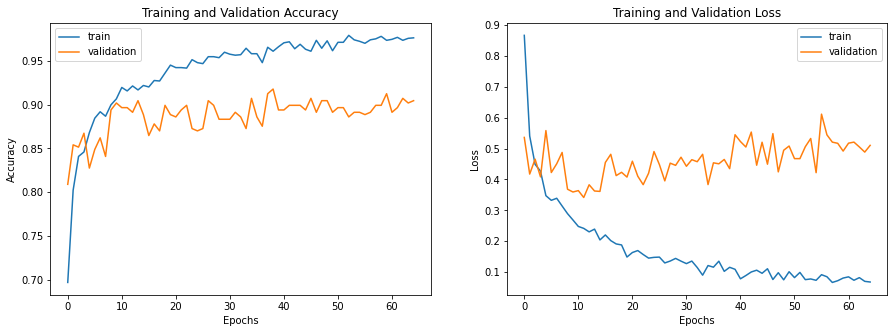

In [ ]:
plot_accuracy_loss(history)

L'accuracy atteint presque les 87%.

## InceptionV3

In [ ]:
modelName = "InceptionV3"

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_inceptionv3 = Architecture(model, nClasses)
model_inceptionv3.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
87924736/87910968 [==============================] - 2s 0us/step


In [ ]:
startTime=time.time()
history = model_inceptionv3.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_inceptionv3.save(f'./Modeles/{modelName}.h5')

Epoch 1/65
56/56 [==============================] - 463s 8s/step - loss: 1.3342 - accuracy: 0.5963 - val_loss: 0.7274 - val_accuracy: 0.7321
Epoch 2/65
56/56 [==============================] - 48s 860ms/step - loss: 0.7466 - accuracy: 0.7339 - val_loss: 0.4984 - val_accuracy: 0.8170
Epoch 3/65
56/56 [==============================] - 48s 851ms/step - loss: 0.6064 - accuracy: 0.7803 - val_loss: 0.5334 - val_accuracy: 0.8064
Epoch 4/65
56/56 [==============================] - 48s 848ms/step - loss: 0.5913 - accuracy: 0.7945 - val_loss: 0.5791 - val_accuracy: 0.7772
Epoch 5/65
56/56 [==============================] - 47s 847ms/step - loss: 0.5510 - accuracy: 0.8046 - val_loss: 0.5176 - val_accuracy: 0.8276
Epoch 6/65
56/56 [==============================] - 47s 844ms/step - loss: 0.5047 - accuracy: 0.8250 - val_loss: 0.5305 - val_accuracy: 0.8249
Epoch 7/65
56/56 [==============================] - 48s 847ms/step - loss: 0.4735 - accuracy: 0.8347 - val_loss: 0.5679 - val_accuracy: 0.7984
E

In [ ]:
study_model(model_inceptionv3, labels, test_generator, executionTime)

Durée d'entraînement : 3538.52 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.867188   0.871581  0.867188  0.865813


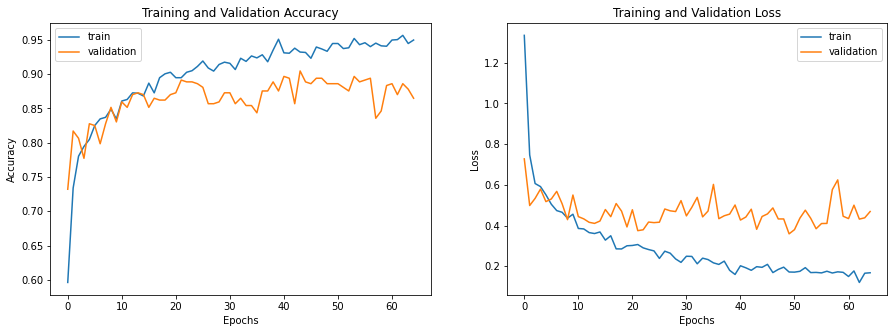

In [ ]:
plot_accuracy_loss(history)

## InceptionResNetV2

In [ ]:
modelName = "InceptionResNetV2"

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = InceptionResNetV2(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_inception_resnet_v2 = Architecture(model, nClasses)
model_inception_resnet_v2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
219070464/219055592 [==============================] - 4s 0us/step


In [ ]:
startTime=time.time()
history = model_inception_resnet_v2.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_inception_resnet_v2.save(f'./Modeles/{modelName}.h5')

Epoch 1/65
56/56 [==============================] - 486s 8s/step - loss: 1.0852 - accuracy: 0.6427 - val_loss: 0.6033 - val_accuracy: 0.8011
Epoch 2/65
56/56 [==============================] - 77s 1s/step - loss: 0.6870 - accuracy: 0.7605 - val_loss: 0.5086 - val_accuracy: 0.8196
Epoch 3/65
56/56 [==============================] - 77s 1s/step - loss: 0.5958 - accuracy: 0.7990 - val_loss: 0.4844 - val_accuracy: 0.8408
Epoch 4/65
56/56 [==============================] - 77s 1s/step - loss: 0.5726 - accuracy: 0.8035 - val_loss: 0.4716 - val_accuracy: 0.8276
Epoch 5/65
56/56 [==============================] - 77s 1s/step - loss: 0.5088 - accuracy: 0.8335 - val_loss: 0.4551 - val_accuracy: 0.8355
Epoch 6/65
56/56 [==============================] - 77s 1s/step - loss: 0.4886 - accuracy: 0.8165 - val_loss: 0.4356 - val_accuracy: 0.8541
Epoch 7/65
56/56 [==============================] - 77s 1s/step - loss: 0.4714 - accuracy: 0.8347 - val_loss: 0.4856 - val_accuracy: 0.8408
Epoch 8/65
56/56 [=

In [ ]:
study_model(model_inception_resnet_v2, labels, test_generator, executionTime)

Durée d'entraînement : 5430.35 secondes

Performances sur le set de test : 

   accuracy  precision  recall  f1-score
0     0.875    0.87738   0.875  0.873648


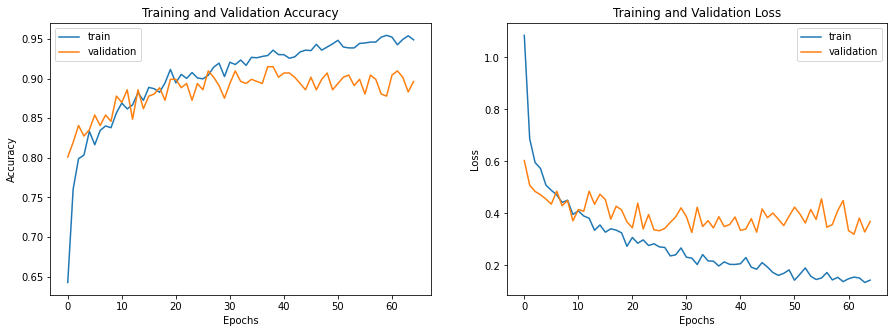

In [ ]:
plot_accuracy_loss(history)

## MobileNet

In [ ]:
modelName = "MobileNet"

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = MobileNet(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_mobilenet = Architecture(model, nClasses)
model_mobilenet.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
startTime=time.time()
history = model_mobilenet.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_mobilenet.save(f'./Modeles/{modelName}.h5')

Epoch 1/65
56/56 [==============================] - 51s 868ms/step - loss: 1.3955 - accuracy: 0.5464 - val_loss: 0.8314 - val_accuracy: 0.7082
Epoch 2/65
56/56 [==============================] - 40s 708ms/step - loss: 0.8284 - accuracy: 0.6988 - val_loss: 0.6979 - val_accuracy: 0.7427
Epoch 3/65
56/56 [==============================] - 40s 721ms/step - loss: 0.7395 - accuracy: 0.7316 - val_loss: 0.6009 - val_accuracy: 0.7798
Epoch 4/65
56/56 [==============================] - 39s 698ms/step - loss: 0.6486 - accuracy: 0.7684 - val_loss: 0.6322 - val_accuracy: 0.7666
Epoch 5/65
56/56 [==============================] - 39s 697ms/step - loss: 0.5605 - accuracy: 0.8052 - val_loss: 0.5266 - val_accuracy: 0.8064
Epoch 6/65
56/56 [==============================] - 39s 698ms/step - loss: 0.5384 - accuracy: 0.8080 - val_loss: 0.4865 - val_accuracy: 0.8196
Epoch 7/65
56/56 [==============================] - 39s 700ms/step - loss: 0.5102 - accuracy: 0.8341 - val_loss: 0.4615 - val_accuracy: 0.8435

In [ ]:
study_model(model_mobilenet, labels, test_generator, executionTime)

Durée d'entraînement : 2554.67 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.859375   0.860479  0.859375  0.858751


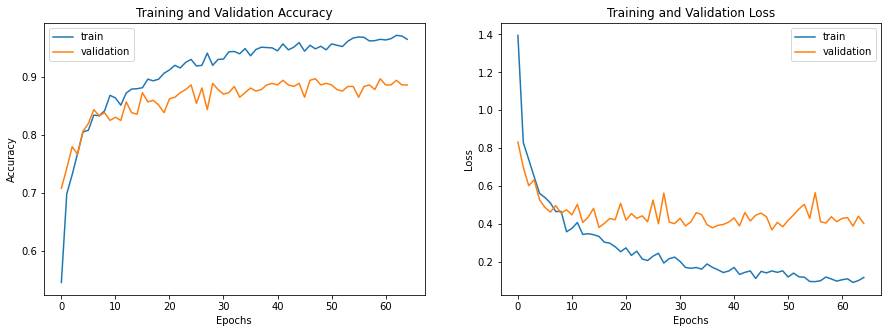

In [ ]:
plot_accuracy_loss(history)

## DenseNet121

In [ ]:
modelName = "DenseNet121"

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = DenseNet121(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_densenet = Architecture(model, nClasses)
model_densenet.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
startTime=time.time()
history = model_densenet.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_densenet.save(f'./Modeles/{modelName}.h5')

Epoch 1/65
56/56 [==============================] - 56s 834ms/step - loss: 1.2187 - accuracy: 0.5781 - val_loss: 0.8699 - val_accuracy: 0.6737
Epoch 2/65
56/56 [==============================] - 43s 761ms/step - loss: 0.7439 - accuracy: 0.7322 - val_loss: 0.6194 - val_accuracy: 0.7851
Epoch 3/65
56/56 [==============================] - 42s 757ms/step - loss: 0.5728 - accuracy: 0.7956 - val_loss: 0.5656 - val_accuracy: 0.8090
Epoch 4/65
56/56 [==============================] - 43s 761ms/step - loss: 0.5283 - accuracy: 0.8131 - val_loss: 0.4374 - val_accuracy: 0.8594
Epoch 5/65
56/56 [==============================] - 42s 755ms/step - loss: 0.4616 - accuracy: 0.8454 - val_loss: 0.4879 - val_accuracy: 0.8196
Epoch 6/65
56/56 [==============================] - 43s 757ms/step - loss: 0.4198 - accuracy: 0.8579 - val_loss: 0.5019 - val_accuracy: 0.8276
Epoch 7/65
56/56 [==============================] - 42s 754ms/step - loss: 0.3727 - accuracy: 0.8630 - val_loss: 0.4116 - val_accuracy: 0.8541

In [ ]:
study_model(model_densenet, labels, test_generator, executionTime)

Durée d'entraînement : 2878.75 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.864583   0.866038  0.864583  0.864339


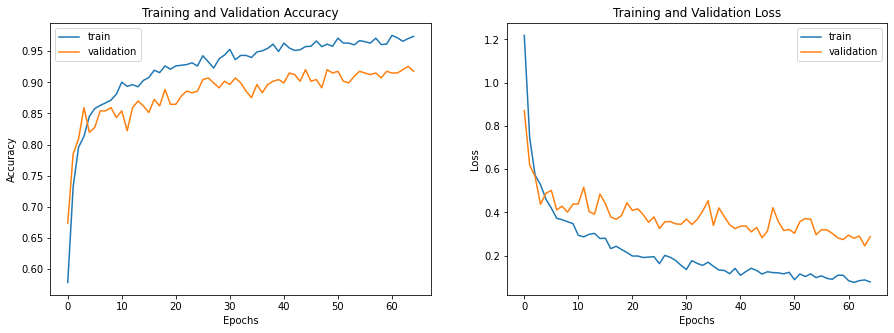

In [ ]:
plot_accuracy_loss(history)

Le modèle n'a peut-être pas totalement convergé.

In [ ]:
model_densenet_2 = load_model(f"./Modeles/{modelName}.h5")
model_densenet_2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
cb_list=[es]
epochs_nb = 35

In [ ]:
startTime=time.time()
history = model_densenet_2.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator, callbacks=cb_list)
executionTime2 = (time.time() - startTime)
model_densenet_2.save(f'./Modeles/{modelName}_2.h5')

Epoch 1/35
56/56 [==============================] - 55s 815ms/step - loss: 0.0842 - accuracy: 0.9677 - val_loss: 0.3433 - val_accuracy: 0.9151
Epoch 2/35
56/56 [==============================] - 44s 782ms/step - loss: 0.0740 - accuracy: 0.9723 - val_loss: 0.2933 - val_accuracy: 0.9231
Epoch 3/35
56/56 [==============================] - 48s 851ms/step - loss: 0.0974 - accuracy: 0.9683 - val_loss: 0.2608 - val_accuracy: 0.9231
Epoch 4/35
56/56 [==============================] - 43s 764ms/step - loss: 0.0923 - accuracy: 0.9689 - val_loss: 0.3334 - val_accuracy: 0.9125
Epoch 5/35
56/56 [==============================] - 44s 779ms/step - loss: 0.0782 - accuracy: 0.9706 - val_loss: 0.3384 - val_accuracy: 0.9072
Epoch 6/35
56/56 [==============================] - 43s 764ms/step - loss: 0.0820 - accuracy: 0.9660 - val_loss: 0.2551 - val_accuracy: 0.9204
Epoch 7/35
56/56 [==============================] - 43s 765ms/step - loss: 0.0811 - accuracy: 0.9717 - val_loss: 0.3097 - val_accuracy: 0.9231

In [ ]:
study_model(model_densenet_2, labels, test_generator, executionTime2)

Durée d'entraînement : 745.85 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.869792    0.87229  0.869792  0.869141


Les performances ont légèrement augmenté grâce quelques epochs supplémentaires mais l'early stopping montre qu'il ne faut pas trop dépasser non plus.

## DenseNet201

In [ ]:
modelName = "DenseNet201"
epochs_nb = 65

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = DenseNet201(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_densenet_201 = Architecture(model, nClasses)
model_densenet_201.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
startTime=time.time()
history = model_densenet_201.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_densenet_201.save(f'./Modeles/{modelName}.h5')

Epoch 1/65
56/56 [==============================] - 486s 8s/step - loss: 1.1105 - accuracy: 0.6280 - val_loss: 0.5836 - val_accuracy: 0.7958
Epoch 2/65
56/56 [==============================] - 45s 806ms/step - loss: 0.6275 - accuracy: 0.7718 - val_loss: 0.4476 - val_accuracy: 0.8276
Epoch 3/65
56/56 [==============================] - 45s 804ms/step - loss: 0.4860 - accuracy: 0.8233 - val_loss: 0.5732 - val_accuracy: 0.7931
Epoch 4/65
56/56 [==============================] - 45s 806ms/step - loss: 0.4367 - accuracy: 0.8431 - val_loss: 0.4096 - val_accuracy: 0.8594
Epoch 5/65
56/56 [==============================] - 45s 804ms/step - loss: 0.4133 - accuracy: 0.8624 - val_loss: 0.3276 - val_accuracy: 0.8833
Epoch 6/65
56/56 [==============================] - 45s 801ms/step - loss: 0.3355 - accuracy: 0.8794 - val_loss: 0.4067 - val_accuracy: 0.8753
Epoch 7/65
56/56 [==============================] - 45s 802ms/step - loss: 0.3382 - accuracy: 0.8851 - val_loss: 0.4581 - val_accuracy: 0.8674
E

In [ ]:
study_model(model_densenet_201, labels, test_generator, executionTime)

Durée d'entraînement : 3466.23 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.869792   0.872244  0.869792  0.868967


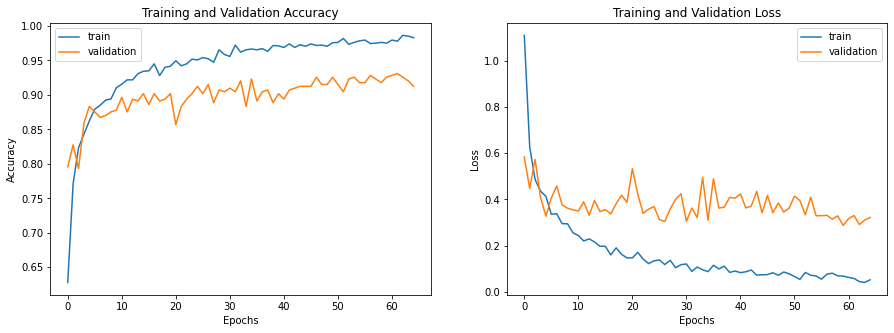

In [ ]:
plot_accuracy_loss(history)

## NASNetLarge

In [ ]:
modelName = "NASNetLarge"

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = NASNetLarge(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_nasnet_large = Architecture(model, nClasses)
model_nasnet_large.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
343621632/343610240 [==============================] - 3s 0us/step


In [ ]:
startTime=time.time()
history = model_nasnet_large.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_nasnet_large.save(f'./Modeles/{modelName}.h5')

Epoch 1/65
56/56 [==============================] - 568s 10s/step - loss: 0.9728 - accuracy: 0.6931 - val_loss: 0.4998 - val_accuracy: 0.8382
Epoch 2/65
56/56 [==============================] - 143s 3s/step - loss: 0.5606 - accuracy: 0.8205 - val_loss: 0.4872 - val_accuracy: 0.8462
Epoch 3/65
56/56 [==============================] - 143s 3s/step - loss: 0.5281 - accuracy: 0.8262 - val_loss: 0.4440 - val_accuracy: 0.8594
Epoch 4/65
56/56 [==============================] - 144s 3s/step - loss: 0.4342 - accuracy: 0.8601 - val_loss: 0.4971 - val_accuracy: 0.8594
Epoch 5/65
56/56 [==============================] - 143s 3s/step - loss: 0.4091 - accuracy: 0.8726 - val_loss: 0.5375 - val_accuracy: 0.8276
Epoch 6/65
56/56 [==============================] - 143s 3s/step - loss: 0.3742 - accuracy: 0.8760 - val_loss: 0.4049 - val_accuracy: 0.8753
Epoch 7/65
56/56 [==============================] - 144s 3s/step - loss: 0.3120 - accuracy: 0.9015 - val_loss: 0.4095 - val_accuracy: 0.8674
Epoch 8/65
5

In [ ]:
study_model(model_nasnet_large, labels, test_generator, executionTime)

Durée d'entraînement : 9736.31 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.885417   0.889389  0.885417  0.884422


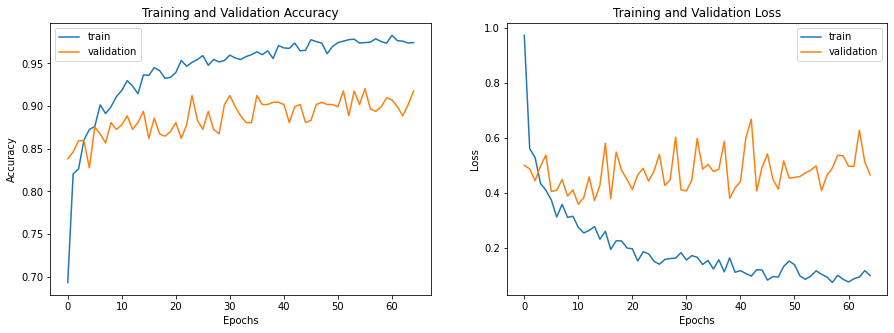

In [ ]:
plot_accuracy_loss(history)

## NASNetMobile

In [ ]:
modelName = "NASNetMobile"

input_shape, train_generator, test_generator, validation_generator =  makeGenerators(modelName, inputFolder, batch_size)
model = NASNetMobile(include_top = False, weights = 'imagenet', input_shape = input_shape)
model_nasnet_mobile = Architecture(model, nClasses)
model_nasnet_mobile.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.
20004864/19993432 [==============================] - 0s 0us/step


In [ ]:
startTime=time.time()
history = model_nasnet_mobile.fit(train_generator, epochs = epochs_nb, validation_data  = validation_generator)
executionTime = (time.time() - startTime)
model_nasnet_mobile.save(f'./Modeles/{modelName}.h5')

Epoch 1/65
56/56 [==============================] - 593s 10s/step - loss: 1.0829 - accuracy: 0.6065 - val_loss: 0.6742 - val_accuracy: 0.7507
Epoch 2/65
56/56 [==============================] - 34s 602ms/step - loss: 0.7447 - accuracy: 0.7356 - val_loss: 0.6633 - val_accuracy: 0.7507
Epoch 3/65
56/56 [==============================] - 34s 605ms/step - loss: 0.6620 - accuracy: 0.7576 - val_loss: 0.5563 - val_accuracy: 0.8037
Epoch 4/65
56/56 [==============================] - 34s 607ms/step - loss: 0.5639 - accuracy: 0.7894 - val_loss: 0.5146 - val_accuracy: 0.8064
Epoch 5/65
56/56 [==============================] - 34s 600ms/step - loss: 0.5425 - accuracy: 0.8035 - val_loss: 0.5622 - val_accuracy: 0.8090
Epoch 6/65
56/56 [==============================] - 33s 592ms/step - loss: 0.4879 - accuracy: 0.8165 - val_loss: 0.5040 - val_accuracy: 0.8276
Epoch 7/65
56/56 [==============================] - 34s 598ms/step - loss: 0.5048 - accuracy: 0.8188 - val_loss: 0.5519 - val_accuracy: 0.8064


In [ ]:
study_model(model_nasnet_mobile, labels, test_generator, executionTime)

Durée d'entraînement : 2744.64 secondes

Performances sur le set de test : 

   accuracy  precision    recall  f1-score
0  0.825521   0.825567  0.825521  0.824128


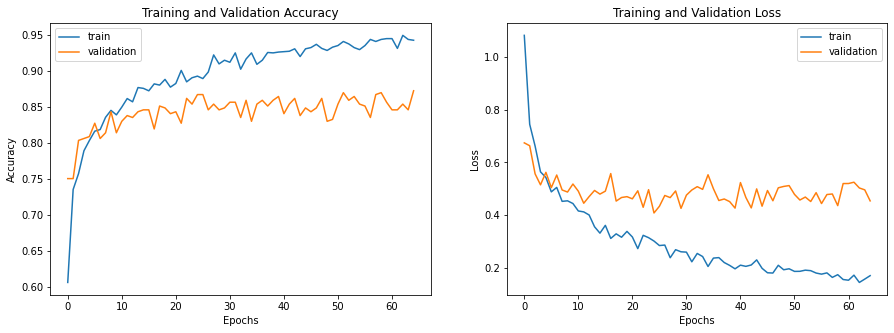

In [ ]:
plot_accuracy_loss(history)

# 3) Comparaison des modèles selon diverses métriques

Nous souhaitons comparer les performances des différents modèles étudiés avec la technique du Transfer Learning, à savoir : VGG16, VGG19, ResNet50, InceptionV3, InceptionResNetV2, MobileNet, DenseNet121, DenseNet201, NASNetLarge, NASNetMobile. Nous pouvons regrouper les résultats obtenus dans un Dataframe en précisant pour chaque modèle son nom, les performances (accuracy, precision, recall, score F1) obtenus sur le dataset de test ainsi que le nombre de paramètres et le temps d'entraînement du modèle sur 65 epochs.

Le but est de sélectionner les meilleurs d'entre eux afin de pousser leur étude avec la variation de divers hyper-paramètres.

In [6]:
def load_model_fill_df(modelName, df, inputFolder):

  model = load_model(f'./Modeles/{modelName}.h5')
  test_generator = testGenerator(modelName, inputFolder)
  preds         = model.predict(test_generator)
  preds_classes = [i.argmax() for i in preds]
  y_true        = test_generator.classes

  acc_test = accuracy_score(y_true, preds_classes)
  prec_test = precision_score(y_true, preds_classes, average='weighted')
  rec_test = recall_score(y_true, preds_classes, average='weighted')
  f1_test = f1_score(y_true, preds_classes, average='weighted')
  params_number = model.count_params() 
  params_number_millions = round(params_number/1000000,1) #conversion en millions

  results = { 'modelName': modelName, 
              'accuracy': acc_test, 
              'precision': prec_test,
              'recall' : rec_test,
              'f1-score' : f1_test,
              'parameters_number (M)' : params_number_millions}

  df = df.append(results, ignore_index = True)

  return df 

In [ ]:
models_list = ["VGG16", "VGG19", "ResNet50", "Xception", "InceptionV3", "InceptionResNetV2", "MobileNet", "DenseNet121", "DenseNet201", "NASNetLarge", "NASNetMobile"]

results_df = pd.DataFrame(columns=['modelName', 'accuracy', 'precision', 'recall', 'f1-score', 'parameters_number (M)'])

for model in models_list:
  results_df = load_model_fill_df(model, results_df, inputFolder)

On trie notre DataFrame dans l'ordre décroissant des valeurs d'accuracy.

In [13]:
results_df = results_df.sort_values(["accuracy"], ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df

,modelName,accuracy,precision,recall,f1-score,parameters_number (M)
0,ResNet50,0.885417,0.887026,0.885417,0.884463,49.3
1,NASNetLarge,0.885417,0.889389,0.885417,0.884422,209.8
2,InceptionResNetV2,0.875000,0.877380,0.875000,0.873648,79.5
3,DenseNet201,0.869792,0.872244,0.869792,0.868967,42.4
4,Xception,0.869792,0.869120,0.869792,0.868050,73.3
5,InceptionV3,0.867188,0.871581,0.867188,0.865813,55.4
6,DenseNet121,0.864583,0.866038,0.864583,0.864339,19.9
7,MobileNet,0.859375,0.860479,0.859375,0.858751,16.1
8,VGG16,0.830729,0.834743,0.830729,0.830348,21.1
9,NASNetMobile,0.825521,0.825567,0.825521,0.824128,17.5


In [14]:
#Ajout du temps d'exécution
execution_time_dict = { 'VGG16' : 2663.36,
                        'VGG19' : 3123.99,
                        'ResNet50' : 2592,
                        'Xception' : 4824.38,
                        'InceptionV3' : 3538.52, 
                        'InceptionResNetV2' : 5430.35, 
                        'MobileNet' : 2554.67,
                        'DenseNet121' : 2878.75,
                        'DenseNet201' : 3466.23,
                        'NASNetLarge' : 9736.31,
                        'NASNetMobile' : 2744.64}

#Conversion en minutes
execution_time_dict = dict(map(lambda x: (x[0], round(x[1]/60, 2)), execution_time_dict.items()))

results_df['execution_time (min)'] = results_df['modelName'].map(execution_time_dict)

In [16]:
def colour_numbers(column):
    green    = 'background-color: green;'
    red = 'background-color: red;'     
    default = ''

    maximum_in_column = column.max()
    minimum_in_column = column.min()

    return [red if v == maximum_in_column else green if v == minimum_in_column else default for v in column]  


results_df.style.highlight_max(subset=['accuracy', 'precision', 'recall', 'f1-score'], axis=0).apply(colour_numbers, subset=['parameters_number (M)', 'execution_time (min)'], axis=0)

,modelName,accuracy,precision,recall,f1-score,parameters_number (M),execution_time (min)
0,ResNet50,0.885417,0.887026,0.885417,0.884463,49.300000,43.200000
1,NASNetLarge,0.885417,0.889389,0.885417,0.884422,209.800000,162.270000
2,InceptionResNetV2,0.875000,0.877380,0.875000,0.873648,79.500000,90.510000
3,DenseNet201,0.869792,0.872244,0.869792,0.868967,42.400000,57.770000
4,Xception,0.869792,0.869120,0.869792,0.868050,73.300000,80.410000
5,InceptionV3,0.867188,0.871581,0.867188,0.865813,55.400000,58.980000
6,DenseNet121,0.864583,0.866038,0.864583,0.864339,19.900000,47.980000
7,MobileNet,0.859375,0.860479,0.859375,0.858751,16.100000,42.580000
8,VGG16,0.830729,0.834743,0.830729,0.830348,21.100000,44.390000
9,NASNetMobile,0.825521,0.825567,0.825521,0.824128,17.500000,45.740000


In [18]:
results_df.to_csv("../Results/transfer_learning_compare_models.csv", index=False)

On remarque que 2 modèles atteignent une accuracy maximale de 88,5% : ResNet50 et NASNetLarge.

En revanche, ResNet50 possède 4 fois moins de paramètres et met également 4 fois moins de temps pour s'entraîner. Il paraît donc préférable de conserver ce modèle plutôt que NASNetLarge.

Le modèle suivant (InceptionResNetV2) atteint 87,5% d'accuracy mais possède presque 2 fois plus de paramètres que ResNet50 et met 2 fois plus de temps à s'entraîner.
Très légèrement derrière avec 87% d'accuracy vient DenseNet201 qui est situé entre ResNet50 et InceptionResNetV2 en termes de temps d'entraînement et de nombres de paramètres.

En conclusion, nous pouvons estimer que notre top 3, en combinant performances en termes d'accuracy et de temps de calcul, est constitué de :

- ResNet50

- InceptionResNetV2

- DenseNet201

On peut remarquer qu'il s'agit de modèles utilisant des couches résiduelles.

# 4) Comparaison des meilleurs modèles en fonction des classes

Certains modèles sortent du lot et ont des performances plus élevées allant jusqu'à 88,5% sur le test set. 
Cependant, nous ne savons pas exactement si toutes les classes sont aussi bien prédites. Afin de voir si certains modèles sont meilleurs que d'autres sur certaines classes, nous pouvons étudier le rapport de classification donné par Sklearn.

In [ ]:
def classificationReport(modelName, inputFolder):

    model = load_model(f'./Modeles/{modelName}.h5')
    test_generator = testGenerator(modelName, inputFolder)
    preds         = model.predict(test_generator)
    preds_classes = [i.argmax() for i in preds]
    y_true        = test_generator.classes

    classificationReport = classification_report(y_true, preds_classes, target_names=labels)
    print(classificationReport)

* ResNet50

In [ ]:
modelName = "ResNet50"
classificationReport(modelName, inputFolder)

Found 384 images belonging to 6 classes.
              precision    recall  f1-score   support

       paper       0.95      0.97      0.96        61
       metal       0.89      0.86      0.87        76
   cardboard       0.84      0.92      0.88        62
       trash       0.87      0.93      0.90        90
     plastic       0.88      0.81      0.84        73
       glass       0.94      0.73      0.82        22

    accuracy                           0.89       384
   macro avg       0.89      0.87      0.88       384
weighted avg       0.89      0.89      0.88       384



Le modèle ResNet50 est surtout bon sur la classe papier avec une très bonne précision et rappel.
Il est le moins bon sur la classe verre (à cause du rappel) et sur la classe plastique.

* InceptionResNetV2

In [ ]:
classificationReport("InceptionResNetV2", inputFolder)

Found 384 images belonging to 6 classes.
              precision    recall  f1-score   support

       paper       0.94      0.95      0.94        61
       metal       0.83      0.93      0.88        76
   cardboard       0.91      0.85      0.88        62
       trash       0.88      0.93      0.90        90
     plastic       0.90      0.74      0.81        73
       glass       0.73      0.73      0.73        22

    accuracy                           0.88       384
   macro avg       0.86      0.86      0.86       384
weighted avg       0.88      0.88      0.87       384



InceptionResNetV2 n'a l'air meilleur sur aucune classe à part très légèrement sur le métal (grâce à un rappel plus élevé).

* DenseNet201

In [ ]:
classificationReport("DenseNet201", inputFolder)

Found 384 images belonging to 6 classes.
              precision    recall  f1-score   support

       paper       0.84      0.95      0.89        61
       metal       0.90      0.84      0.87        76
   cardboard       0.83      0.94      0.88        62
       trash       0.88      0.88      0.88        90
     plastic       0.91      0.81      0.86        73
       glass       0.84      0.73      0.78        22

    accuracy                           0.87       384
   macro avg       0.87      0.86      0.86       384
weighted avg       0.87      0.87      0.87       384



DenseNet201 est légèrement meilleur que ResNet50 pour la classification du plastique avec nottament une meilleure précision.

In [ ]:
classificationReport("NASNetLarge", inputFolder)

Found 384 images belonging to 6 classes.
              precision    recall  f1-score   support

       paper       0.92      0.92      0.92        61
       metal       0.90      0.93      0.92        76
   cardboard       0.78      0.92      0.84        62
       trash       0.90      0.92      0.91        90
     plastic       0.94      0.81      0.87        73
       glass       0.88      0.64      0.74        22

    accuracy                           0.89       384
   macro avg       0.89      0.86      0.87       384
weighted avg       0.89      0.89      0.88       384



Le modèle NASNetLarge est meilleur que les 3 autres sur la classe métal et légèrement sur la classe plastique.

# Conclusion

Le modèle qui paraît le plus intéressant à étudier est le modèle ResNet50.

Il est également pertinent de s'intéresser aux évolutions de ce modèle : ResNet50V2, ResNet101, ResNet101V2, ResNet152 et ResNet152V2.